# This is for plotting mean wind profile under neutral condition #
Note: 1. data with diag_csat_ins >= 65 are discarded in advance.\
2. B1 (the 4th level) uses different CSAT model

2022-3-30

In [30]:
# This jupyter notebook command inserts matplotlib graphics in 
# to the workbook
%matplotlib inline

# import packages
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os.path
import pickle
import time
from matplotlib.pyplot import figure
import scipy.io as sio
from datetime import date, timedelta
from math import *
from scipy.stats import gmean
from scipy import ndimage
from scipy import stats

# directories
IN_DIRECTORY = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/basic_processed_data/"
IN_DIRECTORY2 = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/processed_data/"
msk_DIR = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/mask_data/"
OUT_DIRECTORY = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/neutral_data_20200925_20210423/"
PLOT_DIRECTORY = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/fig_neutral/"
ins_var=['u_ins'] # 36000 instantaneous variables per hour 
# tur_var=['u_tur'] # 36000 instantaneous variables per hour
tur_var=['u_tur3d','v_tur3d','w_tur3d'] # 36000 instantaneous variables per hour
avg_var=['u_avg','u_star','L_H2','v_avg','w_avg','u_std','v_std','w_std','T_avg','rot_ang_v'] # 1 averaged variable per hour
flg_var=['diag_csat_ins','sig_irga_ins']
msk = ['mask_INL_all_1d']
out_var=['neutral_case','u_star_mean','temp_stability','kappa_m2',
         'kappa_m2_stability_corrected','u_star_dev','u_star_m1_sel_dev',
         'u_star_m1_dev','u_star_m1_sel','u_star_m1','u_star_fit','u_star_m2',
         'zo_m1','zo_m1_sel','u_avg_neutral','v_avg_neutral','w_avg_neutral',
         'u_star_m1_dev_abs_mean','u_star_m1_sel_dev_abs_mean','u_star_m2_dev_abs_mean',
         'u_std_neutral','v_std_neutral','w_std_neutral',
         'ist_before','r2_m1','r2_m1_sel','r2_m2',
         'u_star_m2_dif']

## Define constants and labels ##

In [5]:
# EC settings
sonum    =12                       # number of sonic
z        = np.array([1.2,2,3.5,6,8.2,12.8,15.8,23,30.3,40.2,50.6,60.5])                # height of sonic above ground, m
frequency=10                   # sampling frequency, Hz
time_avg =3600                  # average time, s
rpat = time_avg*frequency           # number of lines for a loop

# physical constants (or values that are assumed constant)
Rw  = 461.5     # ideal gas constant for water vapor, J/kg*K
Rd  = 287.05    # ideal gas constant for dry air, J/kg*K
Lv  = 1000*2257 # latent heat of vaporization (water), J/kg
Cp  = 1005      # approximate constant pressure specific heat of air, J/kg*K
kappa   = 0.4       # Von Karman constant
g   = 9.81      # acceleration of gravity, m/s^2
list_col = ['C1','C2','C3','C4','B1','B2','B3','B4','A1','A2','A3','A4']

# selected levels
# list_sel = range(5,11) # from level 6 to level 11
list_sel_m1 = np.array([5,6,7,8,9,10]) # from level 6 to level 11
list_sel_m2 = np.array([5,6,7,8,9,10])
# list_all = np.array([0,1,2,3,6,7,8,9,10,11])
xtick_labels = ["1.2","2","3.5","6","8.2","12.8","15.8","23","30.3","40.2","50.6","60.5"]

load_tur = True
# save_tur = True

## define functions ##

In [3]:
def date_list(sdate,edate):
    """method used for creating date list"""
    delta = edate - sdate       # as timedelta
    day = [sdate+timedelta(days=x) for x in range(delta.days+1)]
    return day

# Load instantaneous data and process data #

In [32]:
%%time
# set up time period and initialize variables
Sdate = date(2020,9,25)
# Edate = date(2020,9,27)
Edate = date(2021,4,23)
ds = date_list(Sdate,Edate)
u_star_mean = []
slope_m1, slope_m1_sel, slope_m2 = [],[],[]
intecept_m1, intecept_m1_sel, intecept_m2 = [],[],[]
zo_m1, zo_m1_sel, zo_m2 = [],[],[]
u_star_m1, u_star_m1_sel,u_star_fit, u_star_m2 = [],[],[],[]
u_star_dev = [] # 2d
u_star_m1_dev,u_star_m1_sel_dev,u_star_m2_dev = [],[],[] # 2d
u_star_m1_dev_abs_mean,u_star_m1_sel_dev_abs_mean,u_star_m2_dev_abs_mean = [],[],[]
kappa_m2 = [] # 1d
neutral_case = [] # list of the occurrence of the neutral cases
u_avg_neutral,v_avg_neutral,w_avg_neutral = [],[],[] # 2d
u_std_neutral,v_std_neutral,w_std_neutral = [],[],[] # 2d
T_avg_neutral,rot_ang_v_neutral = [],[] # 2d
temp_stability = [] # 1d
kappa_m2_stability_corrected = [] # 1d
zo_m2_stability_corrected = [] # 1d
ist_before0,ist_after0 = np.empty(sonum)*np.nan,np.empty(sonum)*np.nan
ist_before,ist_after = [],[]
r2_m1,r2_m1_sel,r2_m2 = [],[],[]
u_star_m1_dif,u_star_m2_dif = [],[]
for day in ds:
    strday = str(day.strftime("%Y%m%d"))
    fp_stats = IN_DIRECTORY + 'u_ins_' + strday +'.pkl'
    if (not os.path.isfile(fp_stats)):
        print(day.strftime("%Y%m%d")+' do not exist')
        continue
    # print('start loading:'+ strday)
    
    # load neutral mask
    b_file = open(msk_DIR + 'mask_neutral_' + strday +'.pkl', "rb")
    mask_neutral = pickle.load(b_file)    
    b_file.close()
    if not any(mask_neutral):
        continue
    # load masks
    for var in msk:
        a_file = open(msk_DIR + var +'_' + strday +'.pkl', "rb")
        globals()[var] = pickle.load(a_file)    
        a_file.close()
    nan_msk=np.isnan(mask_INL_all_1d)
    if all(nan_msk):
        continue
        
    # load avg variables
    for var in avg_var: 
        a_file = open(IN_DIRECTORY + var +'_' + strday +'.pkl', "rb")
        globals()[var] = pickle.load(a_file)    
        a_file.close() 
    
    if load_tur:
        # load tur variables
        for var in tur_var: 
            a_file = open(IN_DIRECTORY + var +'_' + strday +'.pkl', "rb")
            globals()[var] = pickle.load(a_file)    
            a_file.close()
    
    # ---------------- compute log wind profile
    print('start processing:'+ strday)       
    for i in range(24): # loop of hour
        if mask_neutral[i] and (~nan_msk[i]):
            print('neutral case - Hour ' + str(i+1))
            neutral_case.append([day,i+1]) # time index of neutral cases
            
            # save turbulence under neutral conditions
            if save_tur:
                u_tur= u_tur3d[i,:,:]
                v_tur= u_tur3d[i,:,:]
                w_tur= u_tur3d[i,:,:]
                for var in ['u_tur','v_tur','w_tur']:
                    a_file = open(OUT_DIRECTORY + var + '_' + strday +'_'+str(i+1)+'.pkl', "wb")
                    pickle.dump(eval(var), a_file)
                    a_file.close()
            u_avg_neutral = np.append(u_avg_neutral, u_avg[i,:])
            v_avg_neutral = np.append(v_avg_neutral, v_avg[i,:])
            w_avg_neutral = np.append(w_avg_neutral, w_avg[i,:])
            u_std_neutral = np.append(u_std_neutral, u_std[i,:])
            v_std_neutral = np.append(v_std_neutral, v_std[i,:])
            w_std_neutral = np.append(w_std_neutral, w_std[i,:])
            
            # !compute variations of u_star{ec} across vertical levels, 
            # !the mean value is calculated by selected levels
            u_star_mean0 = np.nanmean(u_star[i,list_sel_m1])
            u_star_mean = np.append(u_star_mean, u_star_mean0) # mean of the selected level
            u_star_dev = np.append(u_star_dev, (u_star[i,:]-u_star_mean0)/u_star_mean0, axis=0)

            # !compute u_star by method 1, fit with kappa = 0.4 and using all level data
            mask1 = ~np.isnan(z)
            mask2 = ~np.isnan(u_avg[i,:])
            mask = mask1 & mask2 # mask out nan values
            p1,p2,r_m1,_,_ = stats.linregress(np.log(z[mask]), u_avg[i,mask])
            r2_m1 = np.append(r2_m1,r_m1**2)
            # p1,p2 = np.polyfit(np.log(z[mask]), u_avg[i,mask], deg = 1)
            # print(res.slope-p1)
            # print(res.intercept-p2)
            slope_m1 = np.append(slope_m1, p1)
            intecept_m1 = np.append(intecept_m1,p2)
            zo_m1 = np.append(zo_m1,exp(-p2/p1)) # momentum roughness length           

            u_star_m1_0 = kappa*p1
            u_star_m1 = np.append(u_star_m1,u_star_m1_0)

            # compute variations of u_star across all levels, 
            # the mean value is calculated by method 1 using all level
            u_star_m1_dev0 = (u_star[i,:]-u_star_m1_0)/u_star_m1_0
            u_star_m1_dev = np.append(u_star_m1_dev, u_star_m1_dev0, axis=0)  
            # mean absolute error of u_star to u_star_m1
            u_star_m1_dev_abs_mean = np.append(u_star_m1_dev_abs_mean, 
                                               np.nanmean(abs(u_star_m1_dev0[:])))

            # !compute u_star by method 1, fit with kappa = 0.4 and using selected level data
            p3,p4,r_m1_sel,_,_ = stats.linregress(np.log(z[list_sel_m1]), u_avg[i,list_sel_m1])
            r2_m1_sel = np.append(r2_m1_sel,r_m1_sel**2)
            # p3,p4 = np.polyfit(np.log(z[list_sel_m1]), u_avg[i,list_sel_m1], deg = 1)
            slope_m1_sel = np.append(slope_m1_sel, p3)
            intecept_m1_sel = np.append(intecept_m1_sel,p4)
            zo_m1_sel = np.append(zo_m1_sel,exp(-p4/p3)) # momentum roughness length

            u_star_m1_sel0 = kappa*p3
            u_star_m1_sel = np.append(u_star_m1_sel,u_star_m1_sel0)

            # compute variations of u_star across all levels
            # the mean value is calculated by method 1 using selected level
            u_star_m1_sel_dev0 = (u_star[i,:]-u_star_m1_sel0)/u_star_m1_sel0
            u_star_m1_sel_dev = np.append(u_star_m1_sel_dev, u_star_m1_sel_dev0, axis=0)  
            # mean absolute error of u_star to u_star_m1_sel
            u_star_m1_sel_dev_abs_mean = np.append(u_star_m1_sel_dev_abs_mean, 
                                                   np.nanmean(abs(u_star_m1_sel_dev0[list_sel_m1])))
            print('finish:m1 fitting')
            
            #! method2, fit with ec measured ustar and using selected data
            # This method will give nearly the same zo as method 1 if using
            # the same selected data, the only difference is the kappa value and the u_star
            # 1. u_star is calculated by linearly interpolate to the ground level
            p_u_1,p_u_2 = np.polyfit(z[list_sel_m2], u_star[i,list_sel_m2], deg = 1)
            u_star_fit = np.append(u_star_fit, p_u_2)

            # 2. fit the log wind profile
            p5,p6,r_m2,_,_ = stats.linregress(np.log(z[list_sel_m2]), u_avg[i,list_sel_m2])
            r2_m2 = np.append(r2_m2,r_m2**2)
            # p5,p6 = np.polyfit(np.log(z[list_sel_m2]), u_avg[i,list_sel_m2], deg = 1)
            slope_m2 = np.append(slope_m2, p5)
            intecept_m2_sel = np.append(intecept_m2,p6)
            zo_m2 = np.append(zo_m2,exp(-p6/p5)) # momentum roughness length
            # u_star_m2 is same as u_star_mean
            # since list_sel_m2 = list_sel_m1
            u_star_m2_0 = np.nanmean(u_star[i,list_sel_m2])
            u_star_m2 = np.append(u_star_m2,u_star_m2_0)
            kappa_m2_0 = p_u_2/p5
            kappa_m2 = np.append(kappa_m2, kappa_m2_0)  
            
            # stability parameter
            temp_stability0 = gmean(z[list_sel_m2])/ndimage.median(L_H2[i,list_sel_m2])
            temp_stability = np.append(temp_stability,temp_stability0)
            if temp_stability0 >0: # stable condition
                k_cor = kappa_m2_0*(1+5*temp_stability0)
                kappa_m2_stability_corrected = np.append(kappa_m2_stability_corrected,k_cor)
            else: # unstable condition
                k_cor = kappa_m2_0*(1-16*temp_stability0)**(-1/4)
                kappa_m2_stability_corrected = np.append(kappa_m2_stability_corrected,k_cor)
            # stability corrected roughness length
            zo_cor = exp(-p6/(p_u_2/k_cor))  # !this needs to be revisited
            zo_m2_stability_corrected = np.append(zo_m2_stability_corrected, zo_cor)

            u_star_m2_dev0 = (u_star[i,:]-p_u_2)/p_u_2
            u_star_m2_dev = np.append(u_star_m2_dev, u_star_m2_dev0, axis=0)                
            u_star_m2_dev_abs_mean = np.append(u_star_m2_dev_abs_mean, 
                                               np.nanmean(abs(u_star_m2_dev0[:])))
            # difference between max(u_star) and min(u_star)
            u_star_dif = (np.nanmax(u_star[i,list_sel_m2])-np.nanmin(u_star[i,list_sel_m2]))/np.nanmin(u_star[i,list_sel_m2])
            u_star_m2_dif = np.append(u_star_m2_dif,u_star_dif)
            
            print('finish:m2 fitting')
            
            # non-stationarity index
            for j in list_sel_m2: # for selected level only
                u_tur_temp = u_tur3d[i,:,j].reshape([12,-1]) # split each hour into 12 chunks/every 5 min
                cvm = np.nanmean(np.nanvar(u_tur_temp,axis=1)) # avg of the variance of each chunck
                ist_before0[j] = abs(cvm-np.nanvar(u_tur3d[i,:,j]))/np.nanvar(u_tur3d[i,:,j])
            # print(ist_before0)
            ist_before = np.append(ist_before, ist_before0)

    print('finish processing:'+ strday)
    print('------------------------')

start processing:20200925
neutral case - Hour 16
finish:m1 fitting
finish:m2 fitting
neutral case - Hour 17
finish:m1 fitting
finish:m2 fitting
neutral case - Hour 19
finish:m1 fitting
finish:m2 fitting
finish processing:20200925
------------------------
start processing:20201008
finish processing:20201008
------------------------
start processing:20201010
neutral case - Hour 16
finish:m1 fitting
finish:m2 fitting
neutral case - Hour 21
finish:m1 fitting
finish:m2 fitting
finish processing:20201010
------------------------
start processing:20201011
finish processing:20201011
------------------------
start processing:20201012
neutral case - Hour 17
finish:m1 fitting
finish:m2 fitting
neutral case - Hour 18
finish:m1 fitting
finish:m2 fitting
finish processing:20201012
------------------------
start processing:20201013
neutral case - Hour 14
finish:m1 fitting
finish:m2 fitting
neutral case - Hour 16
finish:m1 fitting
finish:m2 fitting
neutral case - Hour 18
finish:m1 fitting
finish:m2 fi

## Reshape 2D variables ##

In [36]:
u_star_dev = np.reshape(u_star_dev,(-1,12))
u_star_m1_dev = np.reshape(u_star_m1_dev,(-1,12))
u_star_m1_sel_dev = np.reshape(u_star_m1_sel_dev,(-1,12))
u_star_m2_dev = np.reshape(u_star_m2_dev,(-1,12))
u_avg_neutral = np.reshape(u_avg_neutral,(-1,12))
v_avg_neutral = np.reshape(v_avg_neutral,(-1,12))
w_avg_neutral = np.reshape(w_avg_neutral,(-1,12))
u_std_neutral = np.reshape(u_std_neutral,(-1,12))
v_std_neutral = np.reshape(v_std_neutral,(-1,12))
w_std_neutral = np.reshape(w_std_neutral,(-1,12))
ist_before = np.reshape(ist_before,(-1,12))

# Save neutral data #
neutral_case,u_star_mean,temp_stability,kappa_m2,kappa_m2_stability_corrected,u_star_dev,u_star_m1_sel_dev,u_star_m1_dev,u_star_m1_sel,u_star_m1,u_star_m2,zo_m1,zo_m1_sel

In [37]:
for var in out_var:
    a_file = open(OUT_DIRECTORY + var + '.pkl', "wb")
    pickle.dump(eval(var), a_file)
    a_file.close()

# Load neutral data #

In [38]:
for var in out_var:
    a_file = open(OUT_DIRECTORY + var +'.pkl', "rb")
    globals()[var] = pickle.load(a_file)
    a_file.close()

In [39]:
%whos ndarray list 

Variable                       Type       Data/Info
---------------------------------------------------
L_H2                           ndarray    24x12: 288 elems, type `float64`, 2304 bytes
T_avg                          ndarray    24x12: 288 elems, type `float64`, 2304 bytes
T_avg_neutral                  list       n=0
avg_var                        list       n=10
ds                             list       n=211
flg_var                        list       n=2
ins_var                        list       n=1
intecept_m1                    ndarray    71: 71 elems, type `float64`, 568 bytes
intecept_m1_sel                ndarray    71: 71 elems, type `float64`, 568 bytes
intecept_m2                    list       n=0
intecept_m2_sel                ndarray    1: 1 elems, type `float64`, 8 bytes
ist                            ndarray    71: 71 elems, type `float64`, 568 bytes
ist_after                      list       n=0
ist_after0                     ndarray    12: 12 elems, type `float64`, 9

# Let's start plotting ##

In [14]:
## PLOTTING STUFF
## define useful fonts
plt.rc('text', usetex=True)
# plt.rc('font', family='sans-serif')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.weight"] = "bold"
plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13)
font_size = 14

## kappa vs stability, IST, R2, u*_dev ##

In [52]:
y_temp = abs(kappa_m2-0.4)/0.4
y_msk = y_temp<1
y_plus = y_temp[y_msk]
y_mean = np.nanmean(y_plus)
y_sigma = np.nanstd(y_plus)

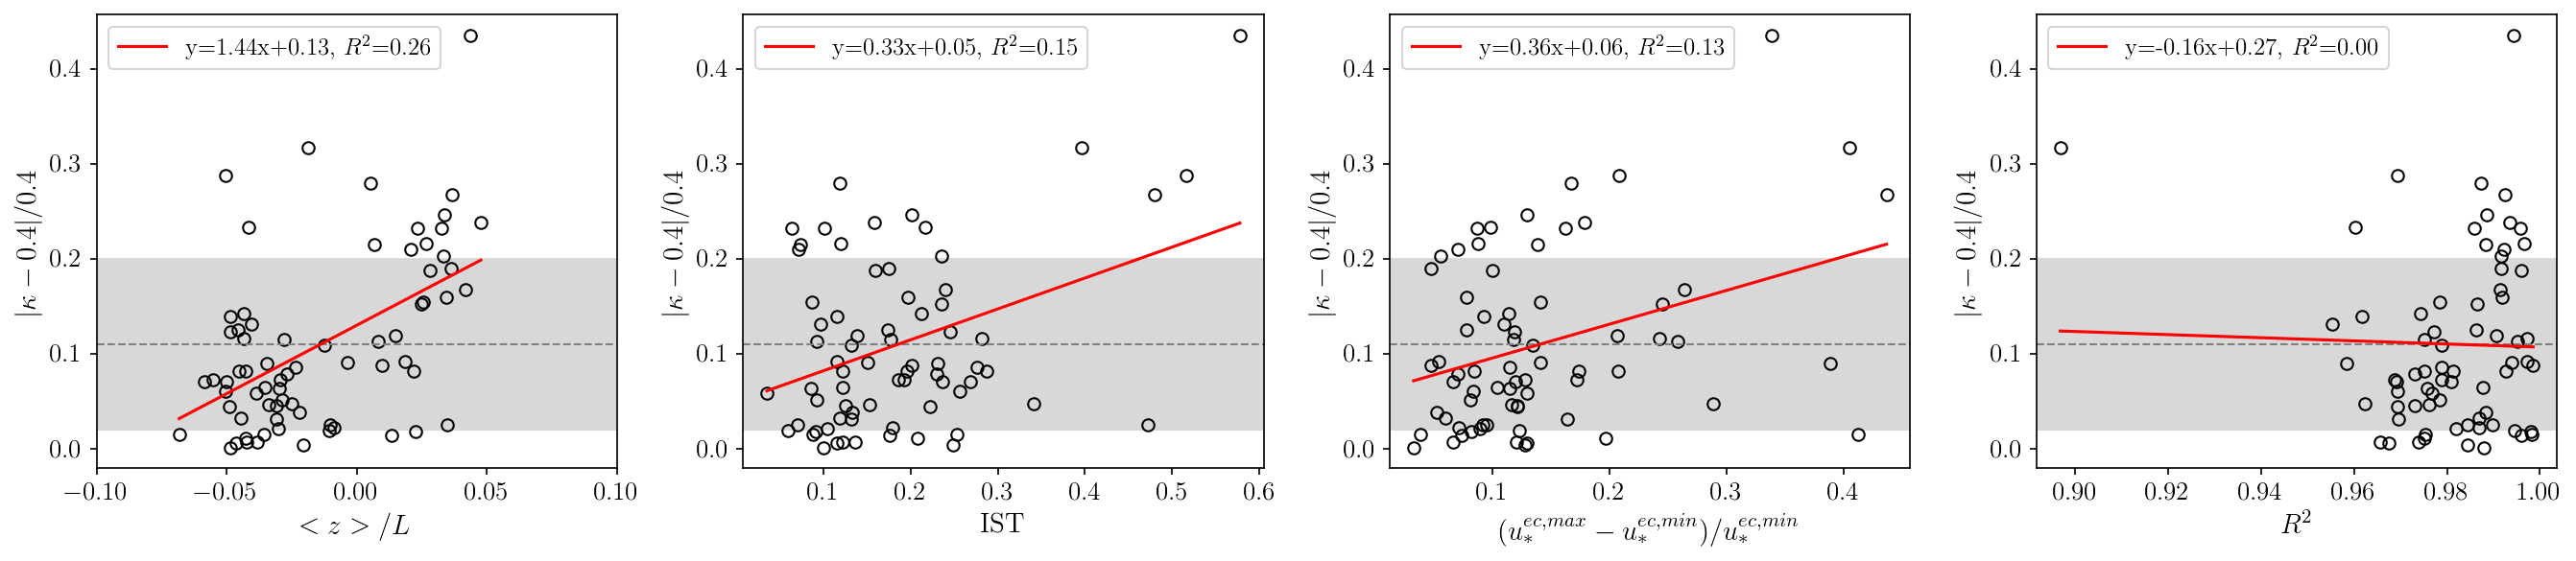

In [53]:
fig = plt.figure(figsize=(18,4), dpi=150,tight_layout=True)
ax1 = fig.add_subplot(141) 
plt.plot(temp_stability[y_msk],y_plus,'o',color = 'k',markerfacecolor='none')
plt.axhline(y=y_mean, color='grey', linestyle='--', linewidth=1)
plt.xlabel(r'\rm $<z>/L$', fontsize=font_size)
plt.ylabel(r'$|\kappa-0.4|/0.4$', fontsize=font_size)
plt.xlim(-0.1,0.1)
# linear regression
slope, intercept,r,_,_ = stats.linregress(temp_stability[y_msk], y_plus)
x = np.sort(temp_stability[y_msk])
line = slope*x+intercept
plt.plot(x, line, 'r', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)
plt.axhspan(y_mean-y_sigma, y_mean+y_sigma, facecolor='0.5', alpha=0.3)

ax2 = fig.add_subplot(142) 
ist = np.nanmean(ist_before, axis=1)
plt.plot(ist[y_msk],y_plus,'o',color = 'k',markerfacecolor='none')
plt.axhline(y=y_mean, color='grey', linestyle='--', linewidth=1)
plt.xlabel(r'IST', fontsize=font_size)
plt.ylabel(r'$|\kappa-0.4|/0.4$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(ist[y_msk], y_plus)
x = np.sort(ist[y_msk])
line = slope*x+intercept
plt.plot(x, line, 'r', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)
plt.axhspan(y_mean-y_sigma, y_mean+y_sigma, facecolor='0.5', alpha=0.3)

ax3 = fig.add_subplot(143) 
plt.plot(u_star_m2_dif[y_msk],y_plus,'o',color = 'k',markerfacecolor='none')
plt.axhline(y=y_mean, color='grey', linestyle='--', linewidth=1)
plt.xlabel(r'$(u_*^{ec,max}-u_*^{ec,min})/u_*^{ec,min}$', fontsize=font_size)
plt.ylabel(r'$|\kappa-0.4|/0.4$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(u_star_m2_dif[y_msk], y_plus)
x = np.sort(u_star_m2_dif[y_msk])
line = slope*x+intercept
plt.plot(x, line, 'r', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)
plt.axhspan(y_mean-y_sigma, y_mean+y_sigma, facecolor='0.5', alpha=0.3)

ax4 = fig.add_subplot(144) 
plt.plot(r2_m2[y_msk],y_plus,'o',color = 'k',markerfacecolor='none')
plt.axhline(y=y_mean, color='grey', linestyle='--', linewidth=1)
plt.xlabel(r'$R^2$', fontsize=font_size)
plt.ylabel(r'$|\kappa-0.4|/0.4$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(r2_m2[y_msk], y_plus)
x = np.sort(r2_m2[y_msk])
line = slope*x+intercept
plt.plot(x, line, 'r', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)
plt.axhspan(y_mean-y_sigma, y_mean+y_sigma, facecolor='0.5', alpha=0.3)

# plt.savefig(PLOT_DIRECTORY + 'k_zol_ist_r2_error1.jpg', dpi=200)

## IST VS u_star_dif ##

Text(0, 0.5, '$(u_*^{ec,max}-u_*^{ec,min})/u_*^{ec,min}$')

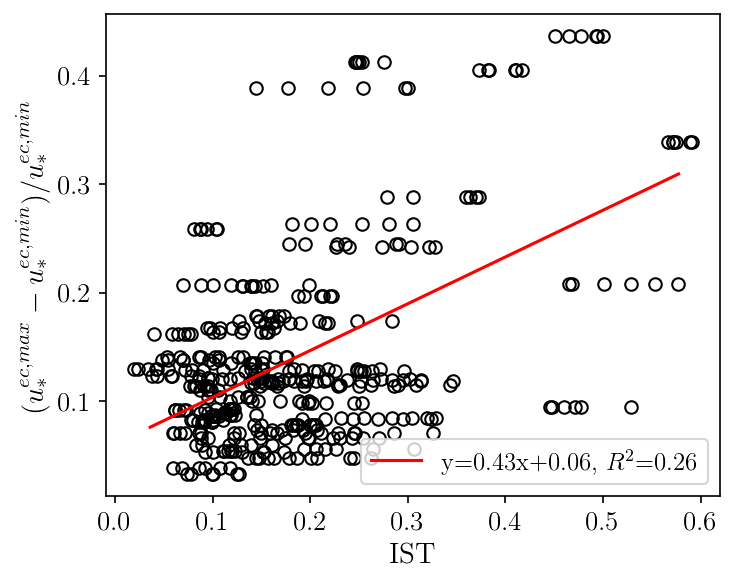

In [51]:
fig = plt.figure(figsize=(5,4), dpi=150,tight_layout=True)
plt.plot(ist_before[y_msk],u_star_m2_dif[y_msk],'o',color = 'k',markerfacecolor='none')
slope, intercept,r,_,_ = stats.linregress(ist[y_msk],u_star_m2_dif[y_msk])
x = np.sort(ist[y_msk])
line = slope*x+intercept
plt.plot(x, line, 'r', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)
plt.xlabel(r'IST', fontsize=font_size)
plt.ylabel(r'$(u_*^{ec,max}-u_*^{ec,min})/u_*^{ec,min}$', fontsize=font_size)

## Kappa vs stability ##

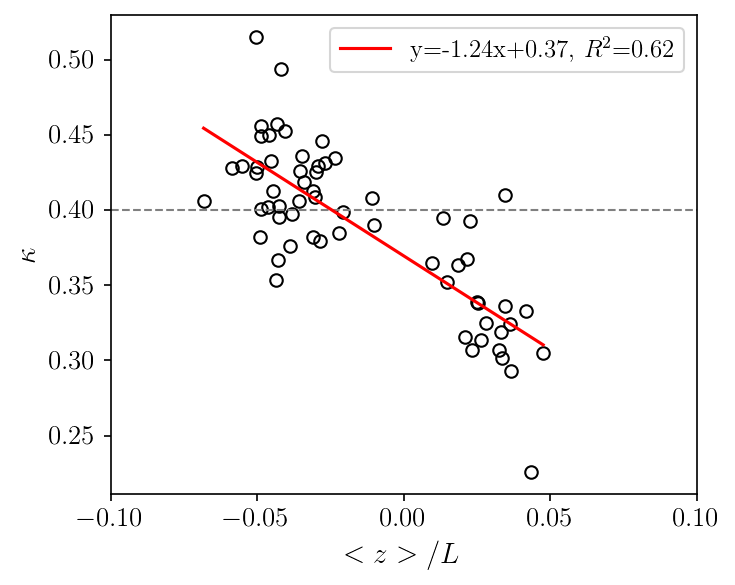

In [7]:
fig = plt.figure(figsize=(5,4), dpi=150,tight_layout=True)
ax1 = fig.add_subplot(111) 
plt.plot(temp_stability,kappa_m2,'o',color = 'k',markerfacecolor='none')
# plt.axvline(x=0, color='grey', linestyle='--', linewidth=1)
plt.axhline(y=0.4, color='grey', linestyle='--', linewidth=1)
plt.xlabel(r'\rm $<z>/L$', fontsize=font_size)
plt.ylabel(r'$\kappa$', fontsize=font_size)
plt.xlim(-0.1,0.1)
# linear regression
slope, intercept,r,_,_ = stats.linregress(temp_stability, kappa_m2)
x = np.sort(temp_stability)
line = slope*x+intercept
plt.plot(x, line, 'r', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)

## neutral case distribution ##

Text(0, 0.5, '\\rm Histogram')

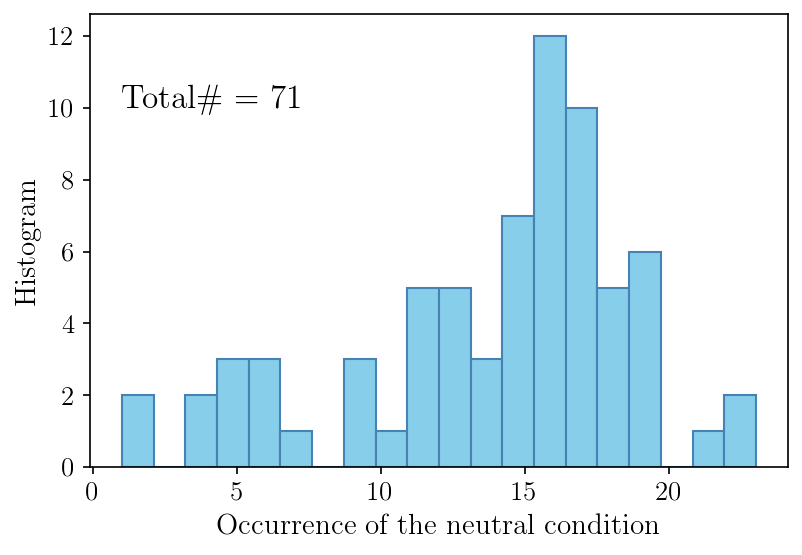

In [40]:
plt.figure(figsize=(6, 4), dpi=150)
_ = plt.hist(np.array(neutral_case)[:,1], color = "skyblue",edgecolor="steelblue", bins=20)  # arguments are passed to np.histogram
# plt.title(r"\rm Histogram of hours", fontsize = 16)
plt.text(1,10,r'Total\# = {:}'.format(len(neutral_case)), fontsize = 16)
plt.xlabel(r'\rm Occurrence of the neutral condition', fontsize = font_size)
plt.ylabel(r'\rm Histogram', fontsize = font_size)
# plt.savefig(PLOT_DIRECTORY + 'neutral_hour_hist.jpg', dpi=200)

## kappa stability corrected value ##

(0.2, 0.6)

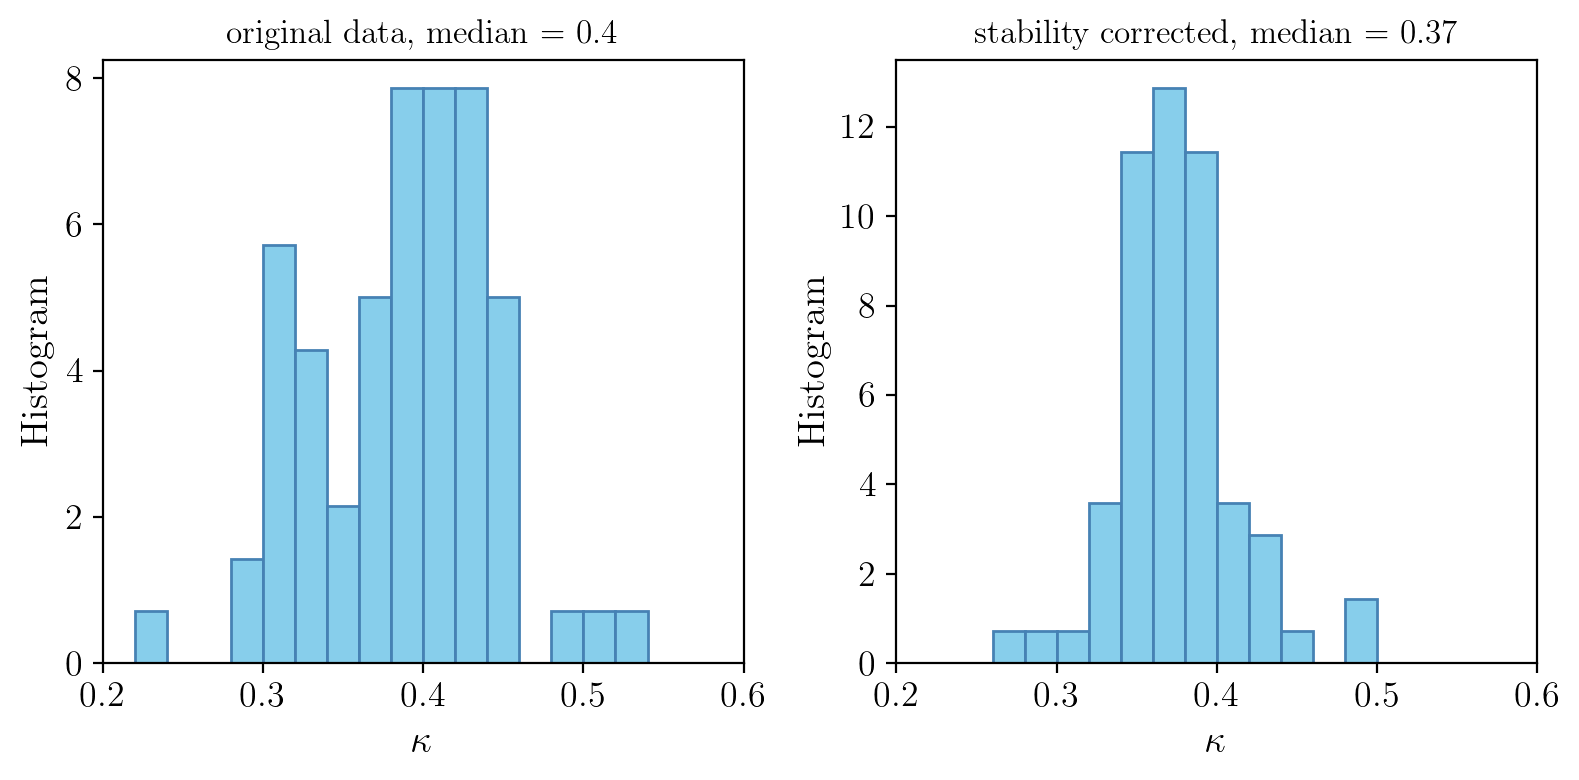

In [54]:
fig = plt.figure(figsize=(8,4), dpi=200,tight_layout=True)
ax1 = fig.add_subplot(121)
_ = plt.hist(kappa_m2, color = "skyblue",edgecolor="steelblue", bins=20, range=(0.2,0.6), density=True)
plt.xlabel(r'$\kappa$', fontsize=font_size)
plt.ylabel(r'\rm Histogram', fontsize = font_size)
ax1.title.set_text("original data, median = "+str(round(ndimage.median(kappa_m2),2)))
plt.xlim(0.2,0.6)

ax2 = fig.add_subplot(122)
_ = plt.hist(kappa_m2_stability_corrected, color = "skyblue",edgecolor="steelblue", bins=20, range=(0.2,0.6), density=True)
plt.xlabel(r'$\kappa$', fontsize=font_size)
plt.ylabel(r'\rm Histogram', fontsize = font_size)
ax2.title.set_text("stability corrected, median = "+str(round(ndimage.median(kappa_m2_stability_corrected),2)))
plt.xlim(0.2,0.6)

# plt.savefig(PLOT_DIRECTORY + 'kappa_values.jpg')

## comparison of u_star across vertical levels ##

Text(0, 0.5, '$\\it (u_*^{ec}-u_*^{ec,mean})/u_*^{ec,mean}$')

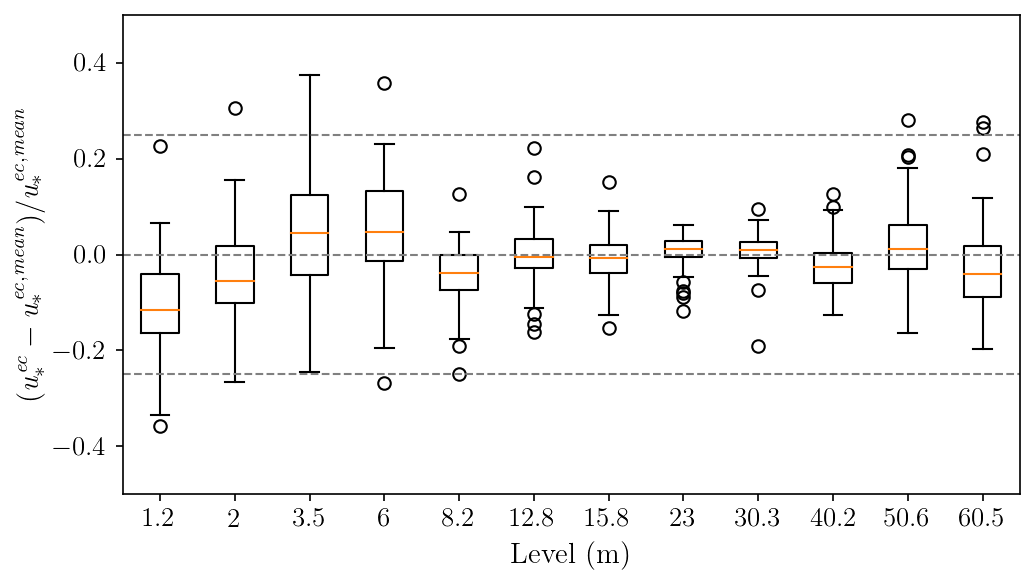

In [55]:
fig = plt.figure(figsize=(7, 4), dpi=150,tight_layout=True)
# Filter data using np.isnan
mask = ~np.isnan(u_star_dev)
filtered_data = [d[m] for d, m in zip(u_star_dev.T, mask.T)]
filtered_data = np.array(filtered_data)
plt.ylim(-0.5,0.5)
plt.boxplot(filtered_data[[0,1,2,3,4,5,6,7,8,9,10,11]])

# plot reference lines
plt.axhline(y=0, color='grey', linestyle='--', linewidth=1)
plt.axhline(y=0.25, color='grey', linestyle='--', linewidth=1)
plt.axhline(y=-0.25, color='grey', linestyle='--', linewidth=1)

# change xticks to be texts
labels = [item.get_text() for item in plt.gca().get_xticklabels()]
labels = [xtick_labels[i] for i in [0,1,2,3,4,5,6,7,8,9,10,11]]
plt.gca().set_xticklabels(labels)

plt.xlabel(r'\rm Level (m)', fontsize=font_size)
plt.ylabel(r'$\it (u_*^{ec}-u_*^{ec,mean})/u_*^{ec,mean}$', fontsize=font_size)

# plt.savefig(PLOT_DIRECTORY + 'ustr_vertical_compare_box.jpg', dpi=200)

## comparison of u_star across two methods ##
### selected levels ###

Text(0, 0.5, '$\\it (u_*^{ec}-u_*^{fit,sel})/u_*^{fit,sel}$')

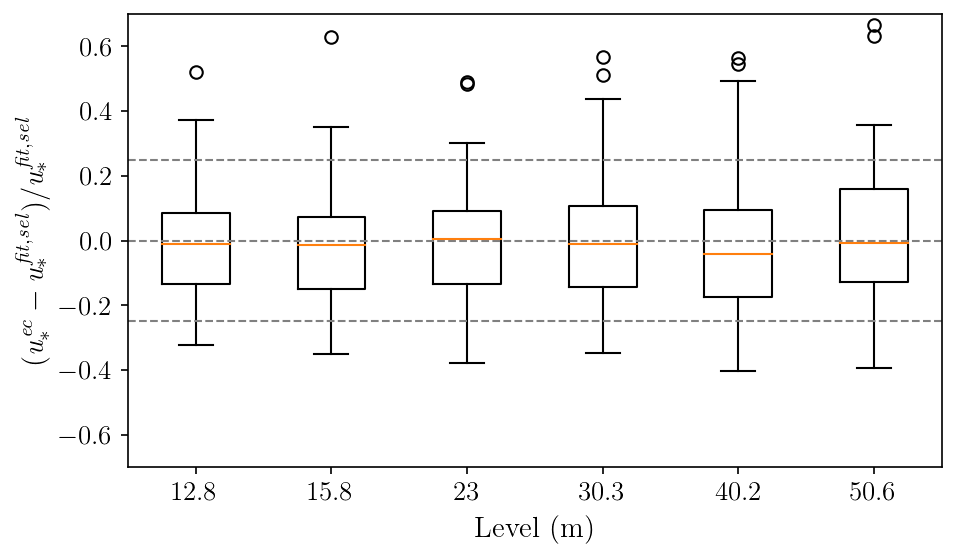

In [56]:
# plt.figure(figsize=(5, 5), dpi=150)
fig, ax = plt.subplots(figsize=(7, 4), dpi=150)
# Filter data using np.isnan
mask = ~np.isnan(u_star_m1_sel_dev)
filtered_data = [d[m] for d, m in zip(u_star_m1_sel_dev.T, mask.T)]
plt.ylim(-0.7,0.7)
plt.boxplot(filtered_data[5:11])

# plot reference lines
plt.axhline(y=0, color='grey', linestyle='--', linewidth=1)
plt.axhline(y=0.25, color='grey', linestyle='--', linewidth=1)
plt.axhline(y=-0.25, color='grey', linestyle='--', linewidth=1)

# change xticks to be texts
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = xtick_labels[5:11]
ax.set_xticklabels(labels)

plt.xlabel(r'\rm Level (m)', fontsize=font_size)
plt.ylabel(r'$\it (u_*^{ec}-u_*^{fit,sel})/u_*^{fit,sel}$', fontsize=font_size)
# plt.savefig(PLOT_DIRECTORY + 'ustr_compare_box_m1_sel_ec.jpg', dpi=200)

### all levels ###

Text(0, 0.5, '$\\it (u_*^{ec}-u_*^{fit,all})/u_*^{fit,all}$')

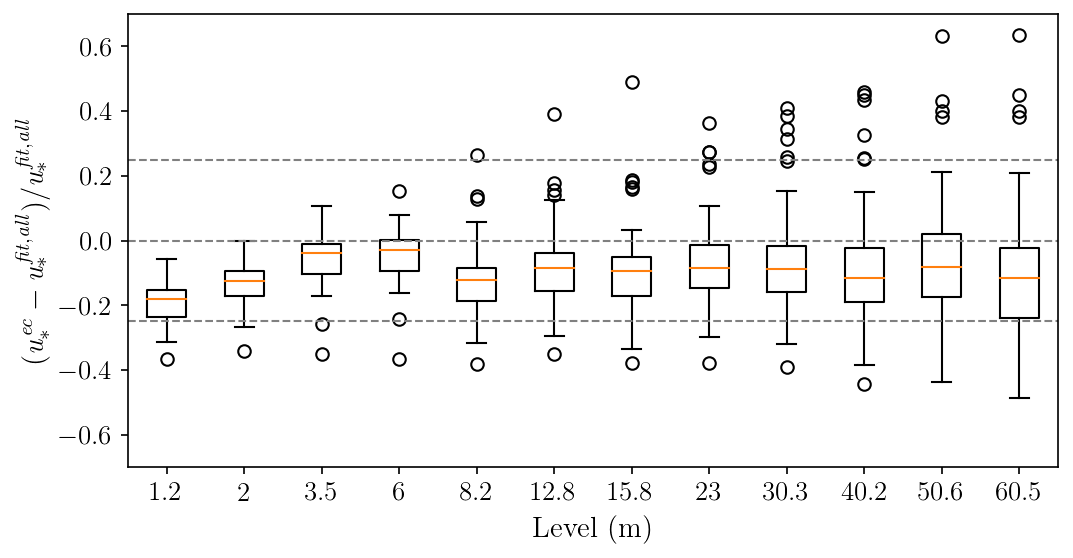

In [57]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=150)
# Filter data using np.isnan
mask = ~np.isnan(u_star_m1_dev)
filtered_data = [d[m] for d, m in zip(u_star_m1_dev.T, mask.T)]
filtered_data = np.array(filtered_data)
plt.ylim(-0.7,0.7)
plt.boxplot(filtered_data[[0,1,2,3,4,5,6,7,8,9,10,11]])

# plot reference lines
plt.axhline(y=0, color='grey', linestyle='--', linewidth=1)
plt.axhline(y=0.25, color='grey', linestyle='--', linewidth=1)
plt.axhline(y=-0.25, color='grey', linestyle='--', linewidth=1)

# change xticks to be texts
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [xtick_labels[i] for i in [0,1,2,3,4,5,6,7,8,9,10,11]]
ax.set_xticklabels(labels)

plt.xlabel(r'\rm Level (m)', fontsize=font_size)
plt.ylabel(r'$\it (u_*^{ec}-u_*^{fit,all})/u_*^{fit,all}$', fontsize=font_size)
# plt.savefig(PLOT_DIRECTORY + 'ustr_compare_box_m1_all_ec.jpg', dpi=200)

## Log wind profile for both methods ##

Text(0, 0.5, '$\\it \\overline{u}$')

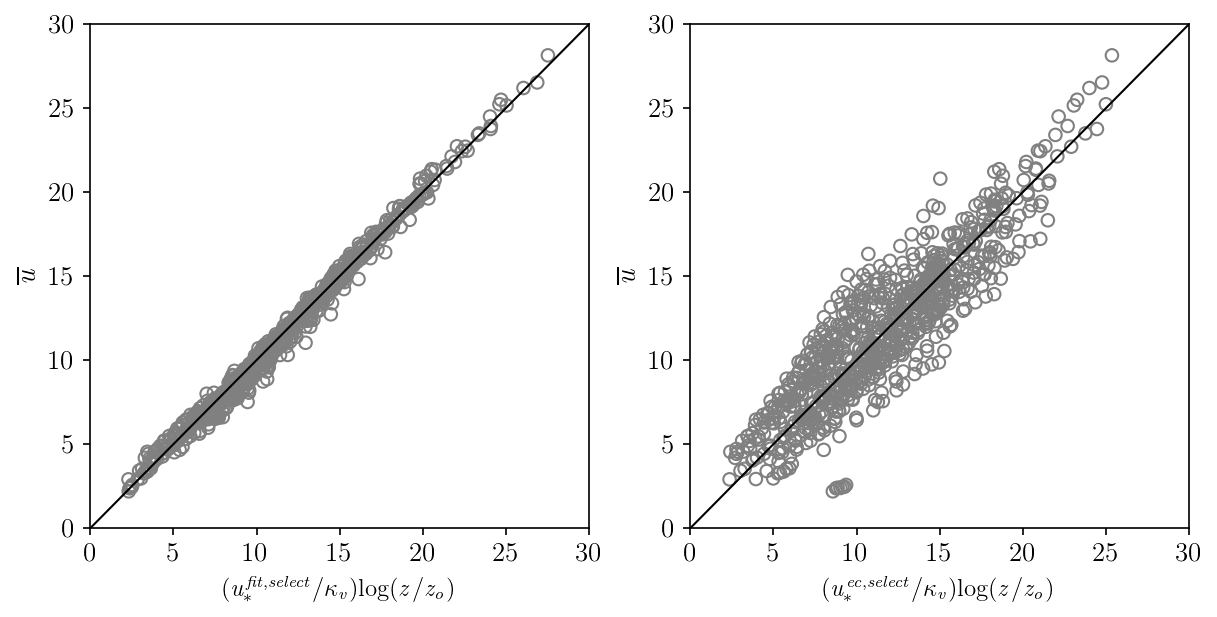

In [58]:
fig, ax = plt.subplots(1,2,figsize=(8, 4), dpi=150,
                                       constrained_layout=True)
ax[0].scatter(u_star_m1_sel/kappa*(np.log(z[:,None]/zo_m1_sel)),u_avg_neutral.T, edgecolors='grey', facecolors='none')
ax[0].set_xlim((0,30))
ax[0].set_ylim((0,30))
# ax = plt.gca()
# x = np.linspace(*ax[0].get_ylim())
# ax[0].plot(x, x, color='black')
ax[0].axline((1, 1), slope=1, color='black', linestyle='solid', linewidth=1)
ax[0].set_xlabel(r'$(\it u_*^{fit,select}/\kappa_v \rm)log(\it z/z_o\rm)$',fontsize=12)
ax[0].set_ylabel(r'$\it \overline{u}$',fontsize=font_size)

ax[1].scatter(u_star_m2/kappa*(np.log(z[:,None]/zo_m1_sel)),u_avg_neutral.T, edgecolors='grey', facecolors='none')
ax[1].set_xlim((0,30))
ax[1].set_ylim((0,30))
ax[1].axline((1, 1), slope=1, color='black', linestyle='solid', linewidth=1)
ax[1].set_xlabel(r'$(\it u_*^{ec,select}/\kappa_v \rm)log(\it z/z_o\rm)$',fontsize=12)
ax[1].set_ylabel(r'$\it \overline{u}$',fontsize=font_size)
# plt.savefig(PLOT_DIRECTORY + 'all_runs_MVP_all_data.jpg', dpi=200)

## scatter plot between two methods ##
### u* fit vs u* mean ###

Text(0, 0.5, '$\\it u_*^{ec}$ (m/s)')

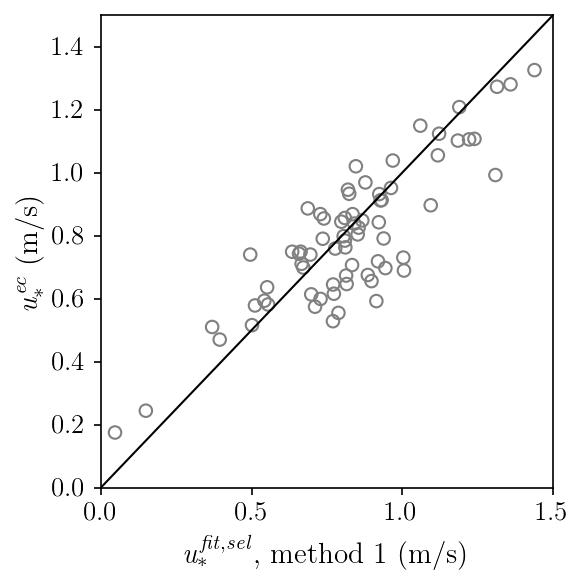

In [59]:
plt.figure(figsize=(4, 4), dpi=150,tight_layout=True)
plt.scatter(u_star_m1_sel,u_star_mean, edgecolors='grey', facecolors='none')
plt.xlim((0,1.5))
plt.ylim((0,1.5))
plt.gca().axline((1, 1), slope=1, color='black', linestyle='solid', linewidth=1)
plt.xlabel(r'$\it u_*^{fit,sel},$ \rm method 1 (m/s)',fontsize=font_size)
plt.ylabel(r'$\it u_*^{ec}$ (m/s)',fontsize=font_size)
# plt.savefig(PLOT_DIRECTORY + 'ustr_scatter_m1_ec.jpg', dpi=200)

### u* mean vs u* interp ###

Text(0, 0.5, '$\\it u_*^{interp}$ (m/s)')

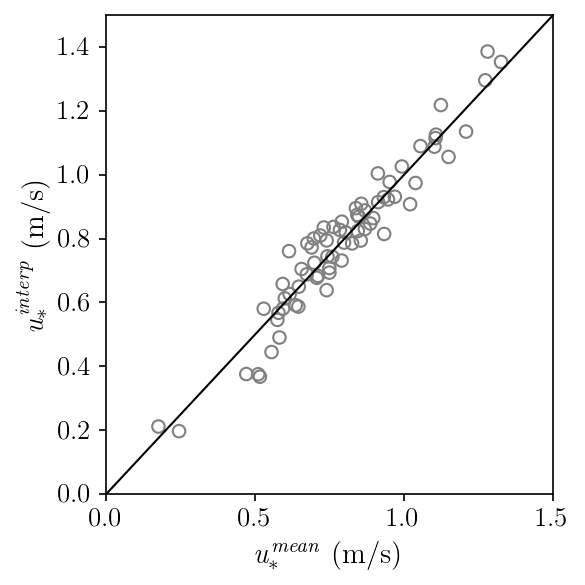

In [60]:
plt.figure(figsize=(4, 4), dpi=150,tight_layout=True)
plt.scatter(u_star_m2,u_star_fit, edgecolors='grey', facecolors='none')
plt.xlim((0,1.5))
plt.ylim((0,1.5))
plt.gca().axline((1, 1), slope=1, color='black', linestyle='solid', linewidth=1)
plt.xlabel(r'$\it u_*^{mean}$ (m/s)',fontsize=font_size)
plt.ylabel(r'$\it u_*^{interp}$ (m/s)',fontsize=font_size)

## Z0 momentum roughness length ##

(0.0, 30.0)

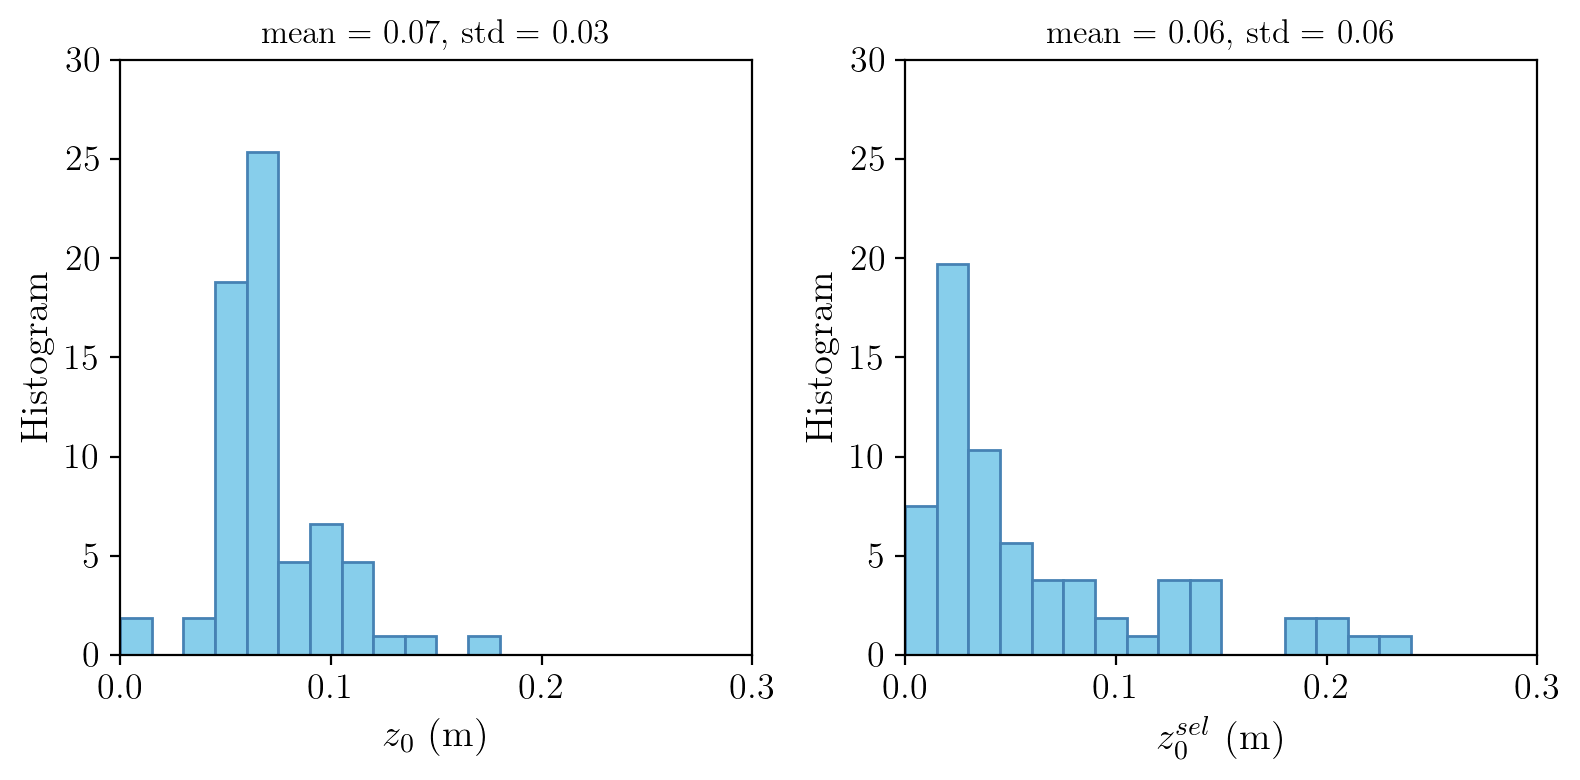

In [61]:
fig = plt.figure(figsize=(8,4), dpi=200,tight_layout=True)
ax1 = fig.add_subplot(121)
_ = plt.hist(zo_m1, color = "skyblue",edgecolor="steelblue", bins=20, range=(0,0.3), density=True)
plt.xlabel(r'$z_0$ (m)', fontsize=font_size)
plt.ylabel(r'\rm Histogram', fontsize = font_size)
ax1.title.set_text("mean = " + str(round(np.nanmean(zo_m1),2))+", std = "+str(round(np.nanstd(zo_m1),2)))
plt.xlim(0,0.3)
plt.ylim(0,30)

ax2 = fig.add_subplot(122)
_ = plt.hist(zo_m1_sel, color = "skyblue",edgecolor="steelblue", bins=20, range=(0,0.3), density=True)
plt.xlabel(r'$z_0^{sel}$ (m)', fontsize=font_size)
plt.ylabel(r'\rm Histogram', fontsize = font_size)
ax2.title.set_text("mean = " + str(round(np.nanmean(zo_m1_sel),2))+", std = "+str(round(np.nanstd(zo_m1_sel),2)))
plt.xlim(0,0.3)
plt.ylim(0,30)

# plt.savefig(PLOT_DIRECTORY + 'z0_values.jpg')